In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from deep_continuation.dataset import DATAPATH

The datasets studied here were obtained witht the following commands:

In [2]:
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555;
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555 --fixstd 8.86;
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555 --fixstd 8.86 --beta [0,60];

100%|█████████████████████████████████████| 10000/10000 [02:52<00:00, 57.92it/s]


In [5]:
pi = {}
pi['no_rescale'   ] = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta30.npy"))
pi['rescale'      ] = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta30_std8.86.npy"))
pi['rescale+randT'] = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta0to60_std8.86.npy"))

sigma = {}
sigma['no_rescale'   ] = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20.npy"))
sigma['rescale'      ] = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20_std8.86.npy"))
sigma['rescale+randT'] = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20_std8.86.npy"))

scale = np.load(os.path.join(DATAPATH, "default", "std_10000x1x1_seed555.npy"))[:,0]


Here are the difference in statistics

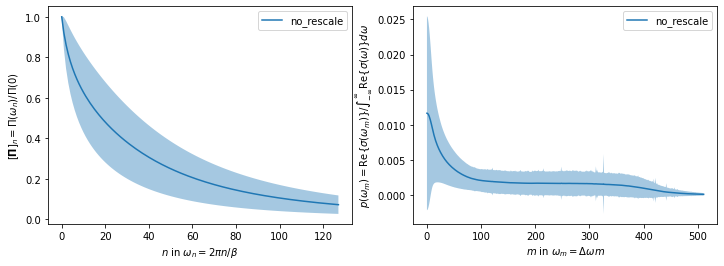

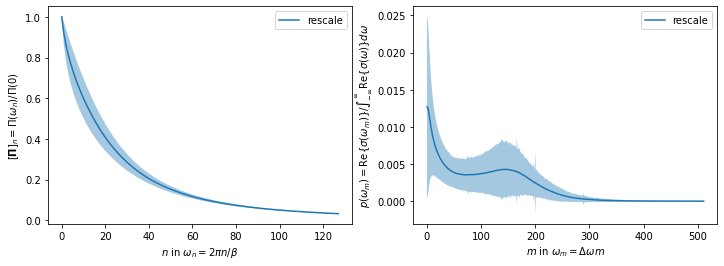

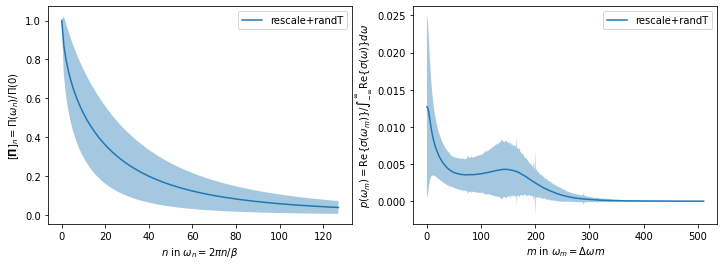

In [18]:
def plot_dataset_stats(sigma, pi, label):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    y = pi
    avg = pi.mean(0)
    std = pi.std(0)
    x=np.arange(128)
    ax[0].plot(x, avg, label=key)
    ax[0].fill_between(x, avg-std, avg+std, alpha=0.4)

    y = sigma
    avg = sigma.mean(0)
    std = sigma.std(0)
    x=np.arange(512)
    ax[1].plot(x, avg, label=label)
    ax[1].fill_between(x, avg-std, avg+std, alpha=0.4)

    ax[0].set_xlabel(r"$n$ in $\omega_n = 2\pi n / \beta$")
    ax[0].set_ylabel(r"$[{\bf \Pi}]_n = \Pi(\omega_n)/\Pi(0)$")
    ax[0].legend()
    ax[1].set_xlabel(r"$m$ in $\omega_m = \Delta\omega m$")
    ax[1].set_ylabel(r"$p(\omega_m) = {\rm Re}\{\sigma(\omega_m)\} / \int_{-\infty}^{\infty} {\rm Re}\{\sigma(\omega)\} d\omega$")
    ax[1].legend()
    plt.show()


for key in pi:
    plot_dataset_stats(sigma[key], pi[key], label=key)

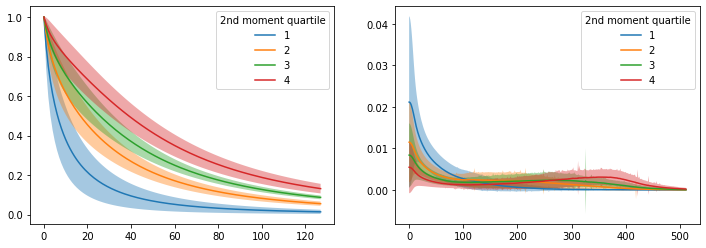

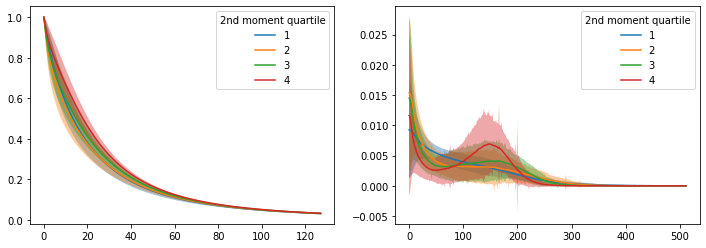

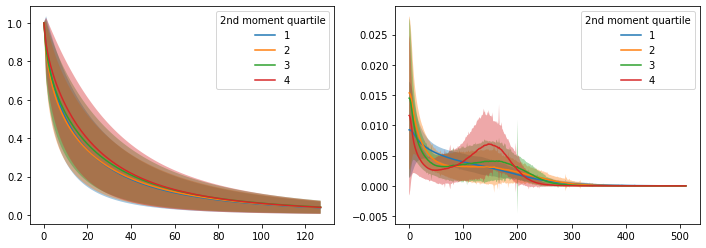

In [19]:
def plot_datasets_stats_by_quartiles(sigma, pi, split_by):
    quartiles = [
        np.quantile(split_by, 0),
        np.quantile(split_by, 0.25),
        np.quantile(split_by, 0.5),
        np.quantile(split_by, 0.75),
        np.quantile(split_by, 1)
    ]
    
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    for i in range(len(quartiles)-1):
        lb = quartiles[i]
        ub = quartiles[i+1]
        mask = np.logical_and(lb<split_by, split_by<ub)
        # print(f"{mask.sum():5.0f} between {lb:.2f} and {ub:.2f}")
        
        y = pi[mask,:]
        avg = pi[mask].mean(0)
        std = pi[mask].std(0)
        x=np.arange(128)
        ax[0].plot(x, avg, label=i+1)
        ax[0].fill_between(x, avg-std, avg+std, alpha=0.4)

        y = sigma[mask,:]
        avg = sigma[mask].mean(0)
        std = sigma[mask].std(0)
        x=np.arange(512)
        ax[1].plot(x, avg, label=i+1)
        ax[1].fill_between(x, avg-std, avg+std, alpha=0.4)
        
    ax[0].legend(title="2nd moment quartile")
    ax[1].legend(title="2nd moment quartile")
    plt.show()

for key in sigma:
    plot_datasets_stats_by_quartiles(sigma[key], pi[key], scale)
    

### Limiting case of a single $p(\omega)$

One particularly clear illustration of the spurious correlation problem with fixed $T$ scheme is when we consider the case of a single reference function $p(\omega)$ and generate a dataset of 10 000 ($\mathbf Pi$, $\mathbf p$)-pairs using different $sp(s\omega)$ at a fix temperature.

In [33]:
!python3 ../deep_continuation/dataset.py --size 1 --num_std 10000 --seed 55555 --fixstd [1,18] --beta 30;

100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 290.61it/s]


A comparable dataset in the fixed $s$ scheme can be obtained with 10 000 temperatures for the same $p(\omega)$.

In [34]:
!python3 ../deep_continuation/dataset.py --size 1 --num_beta 10000 --seed 55555 --fixstd 8.86 --beta [0,60];

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 676948.30it/s]


/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.
/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/ipykernel_launcher.

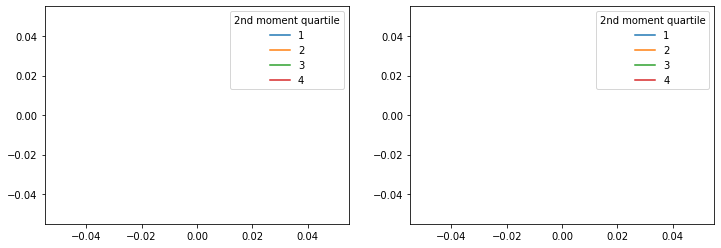

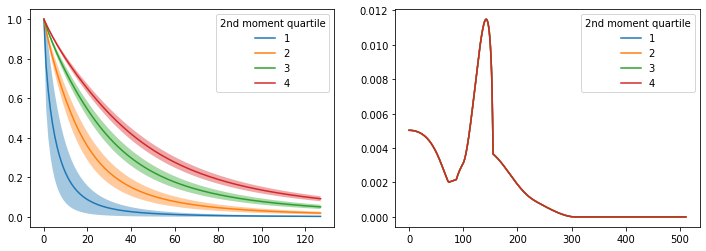

In [40]:
pathological_pi = {}
pathological_pi['fixed T'] = np.load(os.path.join(DATAPATH, "default", "Pi_1x1x10000_seed55555_Nwn128_beta30_std1to18.npy"))
pathological_pi['fixed s'] = np.load(os.path.join(DATAPATH, "default", "Pi_1x10000x1_seed55555_Nwn128_beta0to60_std8.86.npy"))

pathological_sigma = {}
pathological_sigma['fixed T'] = np.load(os.path.join(DATAPATH, "default", "sigma_1x1x10000_seed55555_Nw512_wmax20_std1to18.npy"))
pathological_sigma['fixed s'] = np.load(os.path.join(DATAPATH, "default", "sigma_1x10000x1_seed55555_Nw512_wmax20_std8.86.npy"))

pathological_split_by = {}
pathological_split_by['fixed T'] = np.load(os.path.join(DATAPATH, "default", "std_1x1x10000_seed55555_fixstd1to18.npy"))[:,1]
pathological_split_by['fixed s'] = np.load(os.path.join(DATAPATH, "default", "beta_1x10000x1_seed55555_beta0to60.npy"))

for key in pathological_sigma:
    plot_datasets_stats_by_quartiles(pathological_sigma[key], pathological_pi[key], pathological_split_by[key])

In [39]:
a = pathological_std['fixed s']
print(a)
quartiles = [
        np.quantile(a, 0),
        np.quantile(a, 0.25),
        np.quantile(a, 0.5),
        np.quantile(a, 0.75),
        np.quantile(a, 1)
    ]

for q in quartiles:
    print(q.shape)

[18.2255 18.2255 18.2255 ... 18.2255 18.2255 18.2255]
()
()
()
()
()
